In [1]:
# RYAN SLATTERY
# CS541 - ARTIFICIAL INTELLIGENCE
# HOMEWORK #1: MNIST DATA
# DATE STARTED: NOVEMBER 18, 2022
# LAST MODIFIED: NOVEMBER 23, 2022

In [2]:
# LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
# PREPROCESSING
# READING AND CONVERTING THE FILES:
# I used the following source to help me with converting the files, with slight modifications.
# SOURCE USED: 
# https://quickgrid.blogspot.com/2017/05/Converting-MNIST-Handwritten-Digits-Dataset-into-CSV-with-Sorting-and-Extracting-Labels-and-Features-into-Different-CSV-using-Python.html

# CONVERT DATA FUNCTION:
# INPUT: data (images), n (number of instances)
# OUTPUT: imgs (images in list form)
# This function converts the data instances (a set of images) into a python list.
def convert_data(data, n):
    f = open(data, "rb")
    
    f.read(16)
    imgs = []
    
    for i in range(n):
        img = []
        for j in range(784):
            img.append(ord(f.read(1)))
        imgs.append(img)
    
    f.close()
    return imgs

# CONVERT LABELS FUNCTION:
# INPUT: labels (file of labels), n (number of instances)
# OUTPUT: labels (labels in list form)
# This function converts the labels from the file into a python list.
def convert_labels(labels, n):
    f = open(labels, "rb")
    
    f.read(8)
    labels = []
    
    for i in range(n):
        labels.append(ord(f.read(1)))
    
    f.close()
    return labels

In [4]:
# CONVERTING THE DATA:
train_x = np.array(convert_data("train-images.idx3-ubyte", 60000))
train_y = convert_labels("train-labels.idx1-ubyte", 60000)
test_x = np.array(convert_data("t10k-images.idx3-ubyte", 10000))
test_y = convert_labels("t10k-labels.idx1-ubyte", 10000)

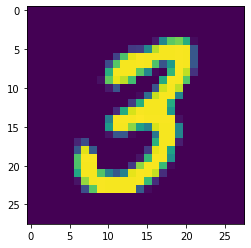

LABEL FOR THIS IMAGE: 3


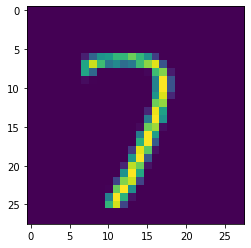

LABEL FOR THIS IMAGE: 7


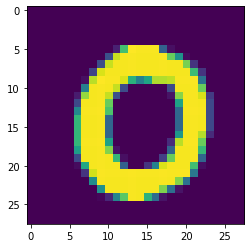

LABEL FOR THIS IMAGE: 0


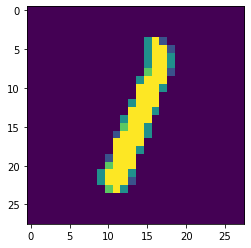

LABEL FOR THIS IMAGE: 1


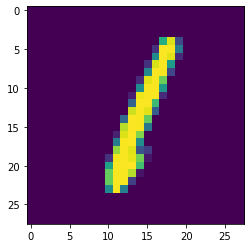

LABEL FOR THIS IMAGE: 1


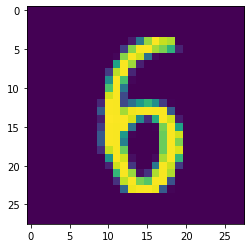

LABEL FOR THIS IMAGE: 6


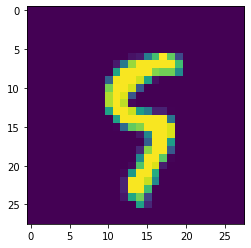

LABEL FOR THIS IMAGE: 9


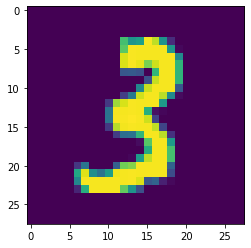

LABEL FOR THIS IMAGE: 3


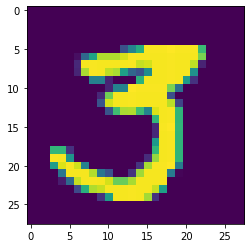

LABEL FOR THIS IMAGE: 3


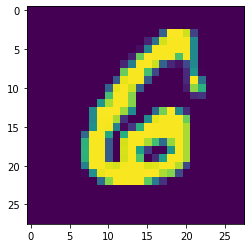

LABEL FOR THIS IMAGE: 6


In [5]:
# DISPLAYING IMAGES AND LABELS FROM THE TRAINING SET:
for i in range(10):
    r = np.random.randint(60000)
    img = train_x[r].reshape(28, 28)
    plt.imshow(img, interpolation='nearest')
    plt.show()
    print("LABEL FOR THIS IMAGE:", train_y[r])

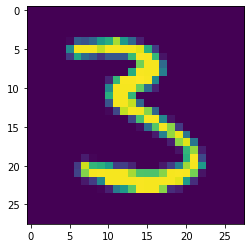

LABEL FOR THIS IMAGE: 3


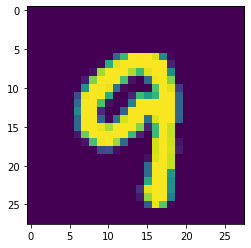

LABEL FOR THIS IMAGE: 9


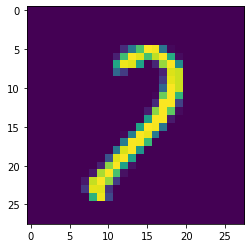

LABEL FOR THIS IMAGE: 7


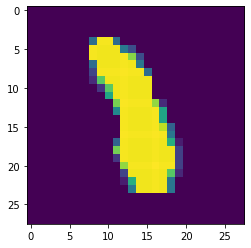

LABEL FOR THIS IMAGE: 1


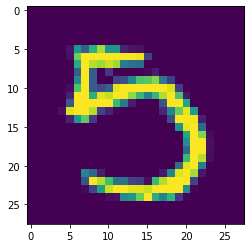

LABEL FOR THIS IMAGE: 5


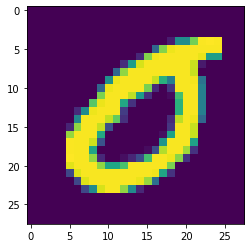

LABEL FOR THIS IMAGE: 0


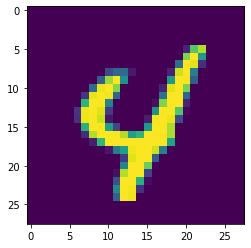

LABEL FOR THIS IMAGE: 4


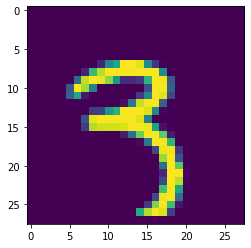

LABEL FOR THIS IMAGE: 3


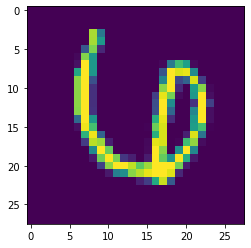

LABEL FOR THIS IMAGE: 6


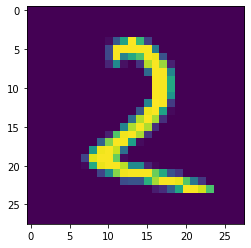

LABEL FOR THIS IMAGE: 2


In [6]:
# DISPLAYING IMAGES AND LABELS FROM THE TEST SET:
for j in range(10):
    r = np.random.randint(10000)
    img = test_x[r].reshape(28, 28)
    plt.imshow(img, interpolation = 'nearest')
    plt.show()
    print("LABEL FOR THIS IMAGE:", test_y[r])

In [7]:
# L2 NORMALIZATION
# Uses formula sqrt(xTx) for each feature vector x

# TRAINING SET NORMALIZATION
l2_train = train_x.astype(float)
for i in range(len(train_x)):
    norm = np.sqrt(np.dot(train_x[i], train_x[i].T))
    l2_train[i] = (l2_train[i] / norm)

# TEST SET NORMALIZATION
l2_test = test_x.astype(float)
for j in range(len(test_x)):
    norm = np.sqrt(np.dot(test_x[j], test_x[j].T))
    l2_test[j] = (l2_test[j] / norm)

In [8]:
# DISTANCE METHOD
# INPUT: x_train (training data), x_test (testing data)
# OUTPUT: dist_mat (a distance matrix)
# This method generates an MxN distance matrix (M being the number of test instances and N being the number of training
# instances) based on the euclidean (L2) distances between each of the training and testing points. This matrix will 
# be used later on to classify the testing instances using a k-nearest neighbors classifier.
def dist(x_train, x_test):
    dist_mat = np.zeros((len(x_test), len(x_train)))
    for i in range(len(x_test)):
        distance = np.sqrt(np.sum((x_test[i] - x_train)**2, axis = 1))
        dist_mat[i] = distance
        
    return dist_mat

# RETRIEVE METHOD:
# INPUT: i (index of a selected training instance), m (distance matrix), k (number of points we are comparing)
# OUTPUT: nearest_neighbors (a list of indices of the nearest training points to our selected instance at i)
# Given an index i for an instance of the test set, this method finds the 3 closest neighbors to test[i] based on the 
# euclidean distances measured in the distance matrix. The first k minimum distances will be selected, representing
# the k-nearest neighbors to test[i]. 
# In order to (a) preserve order/length of the list and accurate selection of indicies, and (b) ensure the minimum 
# value is not selected over and over again, the minimum value is replaced with an unusually large number (1E9 in 
# this case). When the next search is executed, the next minimum value will be selected and replaced with this value 
# as well.
# I used this source to help me find the functions to retrieve the minimum index.
# SOURCE USED: https://www.geeksforgeeks.org/python-maximum-minimum-elements-position-list/
def retrieve_k(i, m, k):
    distances = list(m[i])
    nearest_neighbors = []
    for indx in range(k):
        nn = distances.index(min(distances))
        distances[nn] = 1E9
        nearest_neighbors.append(nn)
    
    return nearest_neighbors

# PRECISION METHOD:
# INPUT: y (test label for a given instance), y_train (training labels), i (list of indices retrieved from the
# retrieve method)
# OUTPUT: prec_k (calculated precision)
# This method calculates the precision of a test instance classified by our training instances. Precision is calculated
# by adding 1 each time the test label matches the training labels, and dividing by k. Precision will be between 0 and
# 1.
def precision_k(y, y_train, i):
    prec_k = 0
    for index in i:
        if (y == y_train[index]):
            prec_k += (1 / len(i))
        
    return prec_k

# AVERAGE PRECISION METHOD:
# INPUT: m (distance matrix), y_train (training labels), y_test (testing labels), k (hyperparameter for # of neighbors)
# OUTPUT: avg_prec (calculated average precision)
# This method calls on the retrieve and precision methods for each test instance and a value of k. Precision is
# calculated for all instances, and the average precision is calculated.
# This function was modified slightly due to the fact that generating the distance matrix takes a good amount of time.
# When it comes to running this function over and over, generating the distance matrix over and over will be quite
# tolling. That is why the distance matrix is passed as a parameter instead.
def avg_precision_k(m, y_train, y_test, k):
    avg_prec = 0
    for i in range(len(m)):
        knn = retrieve_k(i, m, k)
        avg_prec += precision_k(y_test[i], y_train, knn)
        
    avg_prec = (avg_prec / float(len(m)))
    
    return avg_prec

In [9]:
# GENERATING OUR DISTANCE MATRIX:
# As stated in the homework prompt, 15000 training instances and 2500 testing instances were to be used from the
# MNIST data. This takes a little bit of time to generate...
dist_matrix = dist(l2_train[0:15000], l2_test[0:2500])
print(dist_matrix)

[[1.07392717 1.1397808  1.22676781 ... 0.94561459 1.21339435 0.99995028]
 [1.1517042  1.14213475 1.31496549 ... 1.27392082 1.05339123 1.25102192]
 [1.1409795  1.18986695 1.36194237 ... 1.31037135 1.02489886 1.25231353]
 ...
 [1.01518341 0.99217924 1.1422349  ... 0.73609735 1.01121955 0.80144209]
 [1.20988819 1.27965944 0.83770956 ... 1.28908488 1.2896021  1.30563174]
 [1.1748962  1.2041558  0.99596357 ... 1.13069903 1.24284373 1.13266257]]


In [10]:
# GENERATING OUR AVERAGE PRECISIONS FOR EACH K, AND RUNTIME:
k_list = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
precision_list = []

for k in k_list:
    start = time.time()
    avg = avg_precision_k(dist_matrix, train_y, test_y, k)
    end = time.time()
    
    print("Runtime for k =", k, "is:", end - start)
    print("Average Precision for k =", k, "is:", avg, '\n')
    
    precision_list.append(avg)

Runtime for k = 1 is: 3.3646621704101562
Average Precision for k = 1 is: 0.9436 

Runtime for k = 2 is: 5.183499097824097
Average Precision for k = 2 is: 0.936 

Runtime for k = 5 is: 10.273832321166992
Average Precision for k = 5 is: 0.917999999999999 

Runtime for k = 10 is: 18.188706874847412
Average Precision for k = 10 is: 0.9000800000000039 

Runtime for k = 20 is: 33.9644410610199
Average Precision for k = 20 is: 0.8749000000000032 

Runtime for k = 50 is: 83.64851498603821
Average Precision for k = 50 is: 0.8256960000000061 

Runtime for k = 100 is: 171.78658890724182
Average Precision for k = 100 is: 0.7765240000000032 

Runtime for k = 200 is: 336.93781089782715
Average Precision for k = 200 is: 0.7123819999999986 

Runtime for k = 500 is: 841.1128120422363
Average Precision for k = 500 is: 0.6004760000000008 

Runtime for k = 1000 is: 2429.4825043678284
Average Precision for k = 1000 is: 0.4837936000000005 



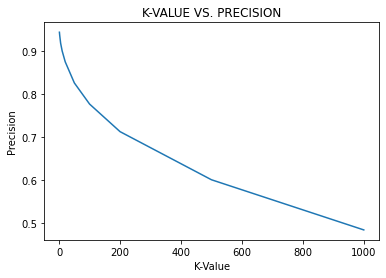

In [12]:
# PLOTTING K-VALUE VS. PRECISION
plt.plot(k_list, precision_list)
plt.title("K-VALUE VS. PRECISION")
plt.xlabel("K-Value")
plt.ylabel("Precision")
plt.show()